# **MRMS/CCRFCD** Rain-Gauge Data Analysis
---

- Time Period: [2021.01.01-2025.07.25]
- **`TODO`**: describe data-collection methodology in detail
- **`TODO`**: explain format of master-dataframe

### 0. Imports & Magic Constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime


ALL_EVENTS_DF = "/playpen/mufan/levi/tianlong-chen-lab/nws-lv-precip-forecasting/ccrfcd-gauge-grids/data/events/2021-01-01_2025-07-25_all_events.csv"

### 1. Whole-Dataset Analysis

In [2]:
df = pd.read_csv(ALL_EVENTS_DF)

# NOTE: filter out extremes
# occasional outlier rain-gauge values appear in the CCRFCD database; CCRFCD does not perform any QC
mask = (df['delta_qpe'] > df['delta_qpe'].quantile(0.001)) & (df['delta_qpe'] < df['delta_qpe'].quantile(0.999))
df   = df.loc[mask].copy()
df.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,cum_gauge_qpe,cum_mrms_qpe
0,2021-01-23 23:00:00,2021-01-24 00:00:00,4709,35.925000,244.883000,0.00,0.003937,-0.003937,0.00,0.003937
1,2021-01-23 23:00:00,2021-01-24 00:00:00,4564,36.028250,244.996361,0.04,0.000000,0.040000,0.04,0.000000
2,2021-01-23 23:00:00,2021-01-24 00:00:00,4779,36.021861,245.041250,0.04,0.000000,0.040000,0.04,0.000000
3,2021-01-23 23:00:00,2021-01-24 00:00:00,4984,35.729250,244.811972,0.00,0.011811,-0.011811,0.00,0.011811
4,2021-01-23 23:00:00,2021-01-24 00:00:00,4724,35.939417,244.922250,0.00,0.015748,-0.015748,0.00,0.015748


In [3]:
print(f"Total number of data points: {len(df)}")
print(f"Number of unique gauges: {len(set(df['station_id']))}")

Total number of data points: 2337407
Number of unique gauges: 223


#### 1.1. Distribution of Events by Date

In [ ]:
dts        = [datetime.strptime(s, "%Y-%m-%d %H:%M:%S") for s in df['start_time']]
unique_dts = list(set(dts))

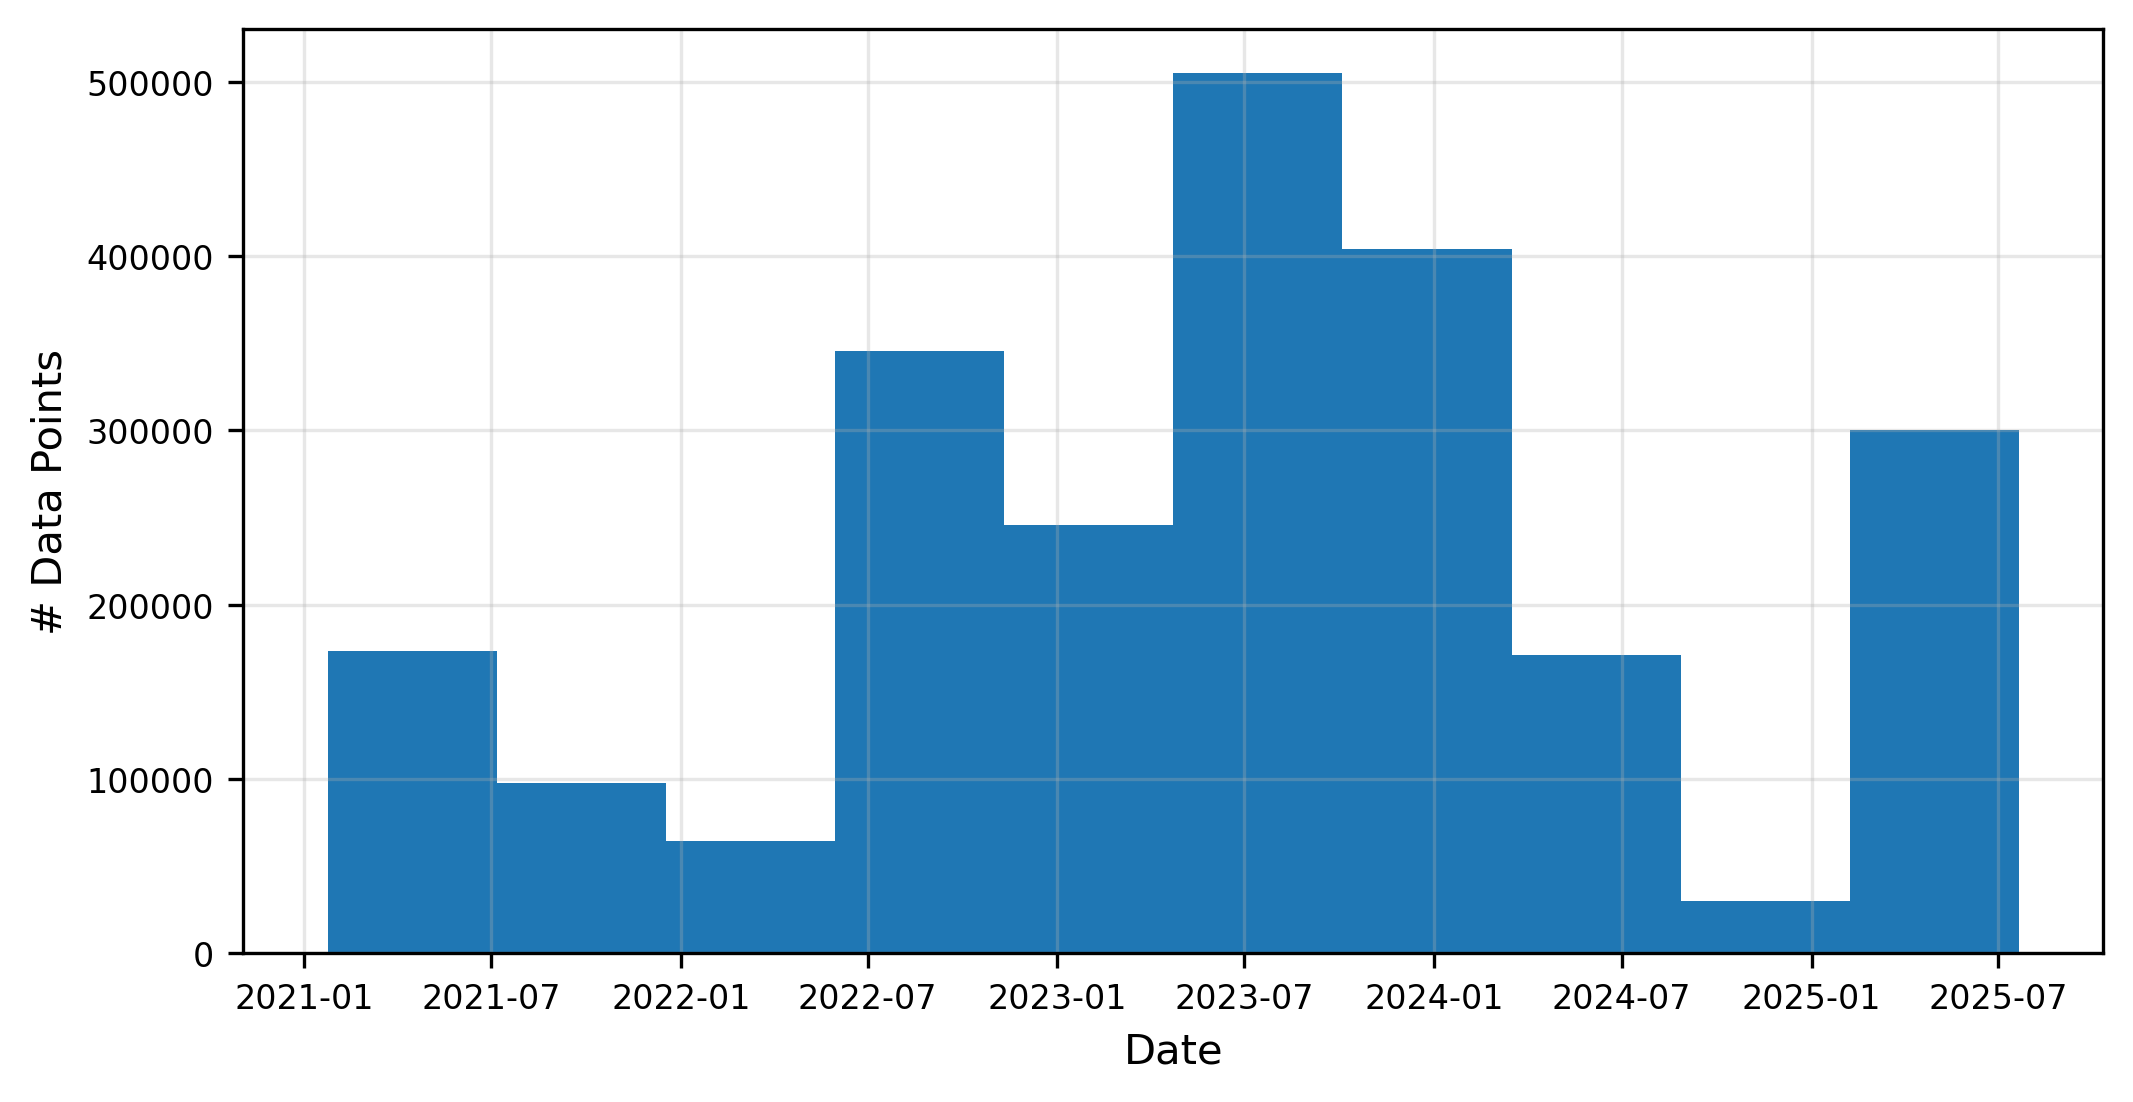

In [133]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
ax.hist(dts)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=8)
plt.ylabel("# Data Points")
plt.yticks(fontsize=8)
plt.show()

#### 1.2. Distribution of `mrms_qpe` by Seasonality

In [109]:
df["start_time"] = pd.to_datetime(df["start_time"])
months = df["start_time"].dt.month

all_values = []
for i in range(1, 13):
    mask       = months.between(i, i)
    delta_qpes = df.loc[mask, "mrms_qpe"].tolist()
    all_values.append(delta_qpes)

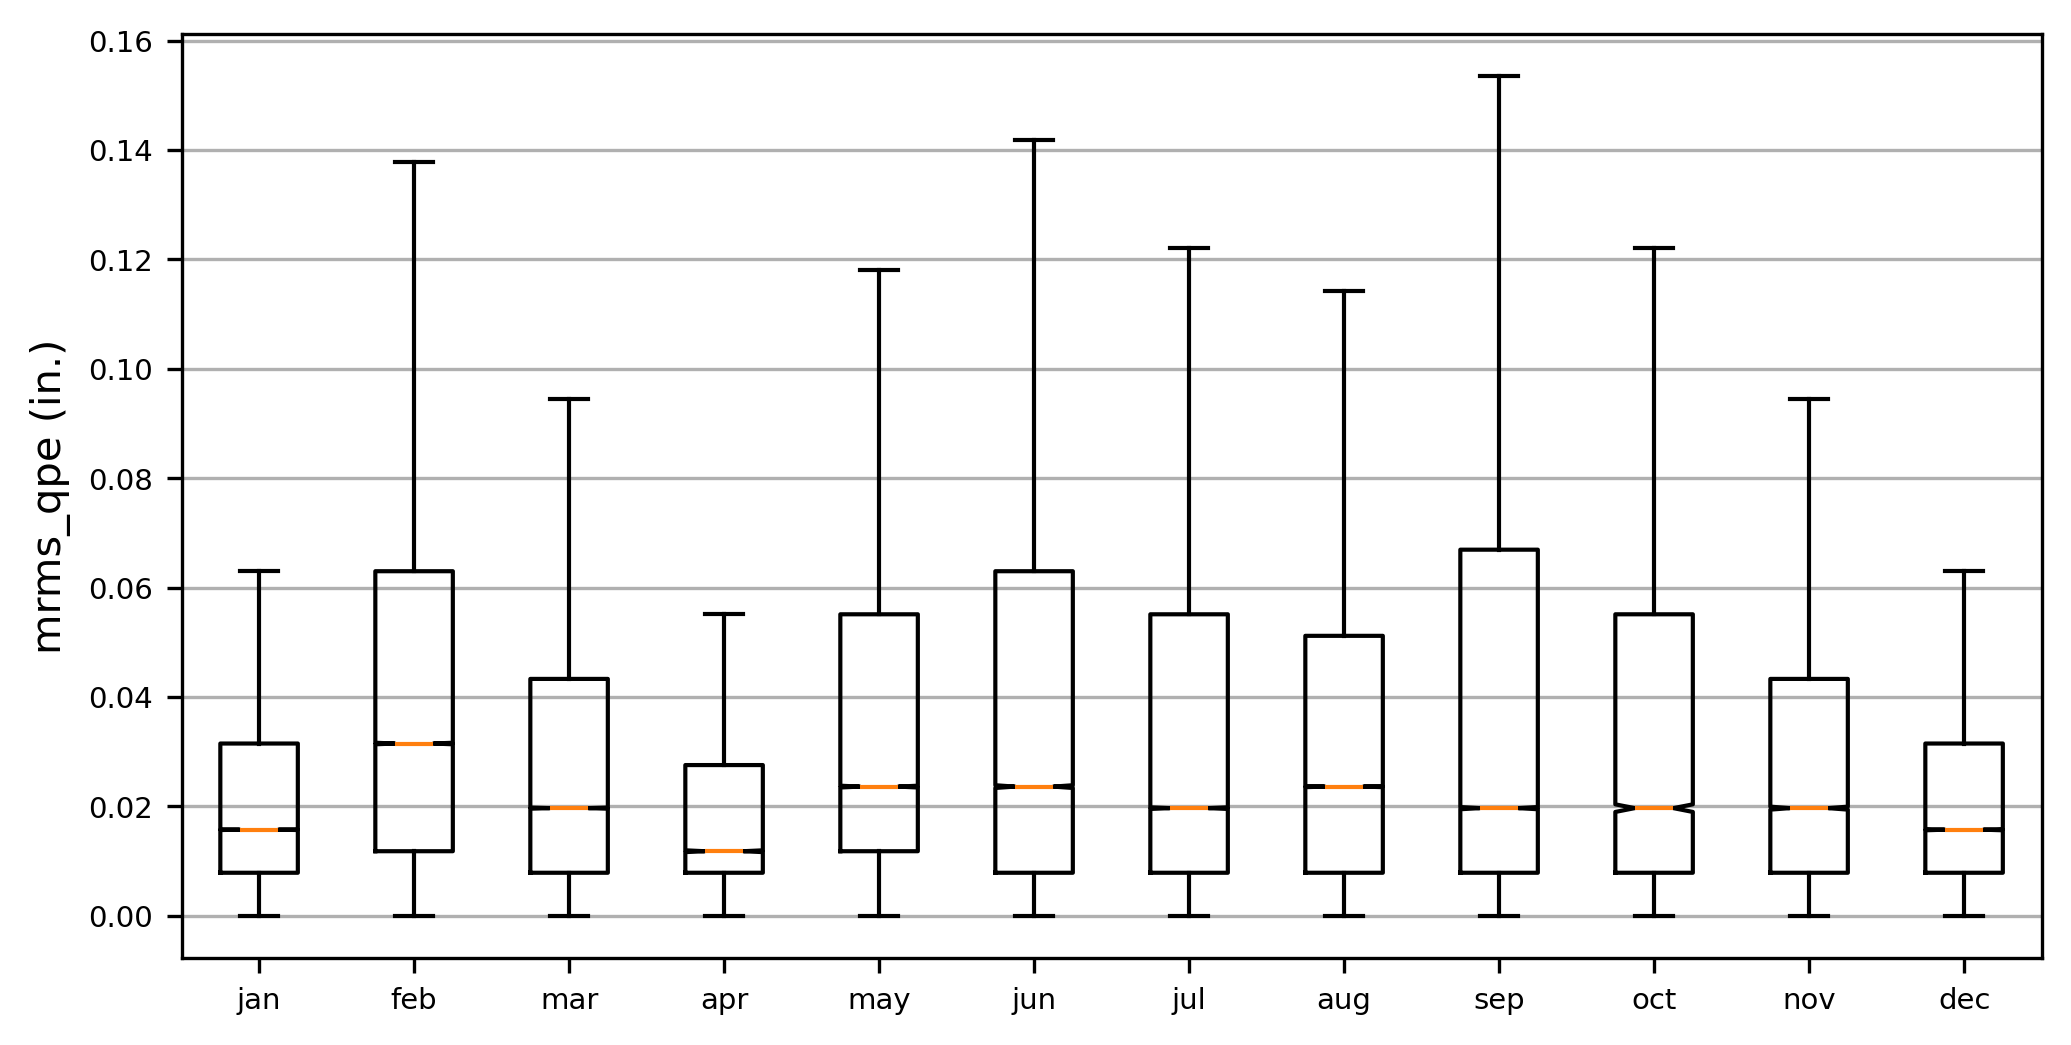

In [116]:
fig, axs = plt.subplots(figsize=(8, 4), dpi=300)
axs.boxplot(
    all_values,
    notch=True,
    showfliers=False,
    )

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(12)],
                  labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel("mrms_qpe (in.)")
plt.show()

### 2. Per-Event Analysis

#### 2.1. Constructing Synthetic "Events"

In [50]:
# cummulative sum of all MRMS values at all gauges for each unique timestep
cum_mrms_qpe = df[['start_time', 'mrms_qpe']].groupby('start_time').sum()['mrms_qpe']
p5           = np.percentile(cum_mrms_qpe, 65)
p95          = np.percentile(cum_mrms_qpe, 95)

series = np.asarray(list(cum_mrms_qpe)[40000:50000])
x      = np.arange(series.size)
p5     = np.percentile(series, 5)
p95    = np.percentile(series, 90)


def segment_rainfall_events(
        precip_array, 
        interval_minutes=2, 
        wet_period_mins=60, 
        dry_period_mins=120, 
        rain_threshold=0.0
    ) -> pd.DataFrame:
    """
    Returns:
        pd.DataFrame: Columns include 'precipitation' and 'is_event' (bool).
    """
    precip_series = pd.Series(precip_array)
    is_rain = (precip_series > rain_threshold).astype(int)

    wet_period_intervals = wet_period_mins // interval_minutes
    dry_period_intervals = dry_period_mins // interval_minutes
    
    rolling_wet = is_rain.rolling(window=wet_period_intervals, min_periods=wet_period_intervals).sum()
    valid_wet_start = (rolling_wet == wet_period_intervals)

    rolling_dry = is_rain.rolling(window=dry_period_intervals, min_periods=dry_period_intervals).sum()
    valid_dry_end = (rolling_dry == 0)

    is_event = np.zeros_like(is_rain, dtype=bool)

    in_event = False
    start_idx = 0

    for i in range(len(is_rain)):
        if not in_event:

            # Wait until a valid wet period starts
            if valid_wet_start.iloc[i]:
                in_event = True
                start_idx = i - wet_period_intervals + 1  # start of rain
        else:
            
            # If inside an event, check for a valid dry period to end the event
            if valid_dry_end.iloc[i]:
                end_idx = i - dry_period_intervals + 1
                is_event[start_idx:end_idx] = True
                in_event = False

    if in_event:
        is_event[start_idx:] = True

    return pd.DataFrame({
        'precipitation': precip_series,
        'is_event': is_event
    })


rainfall_events = segment_rainfall_events(series)

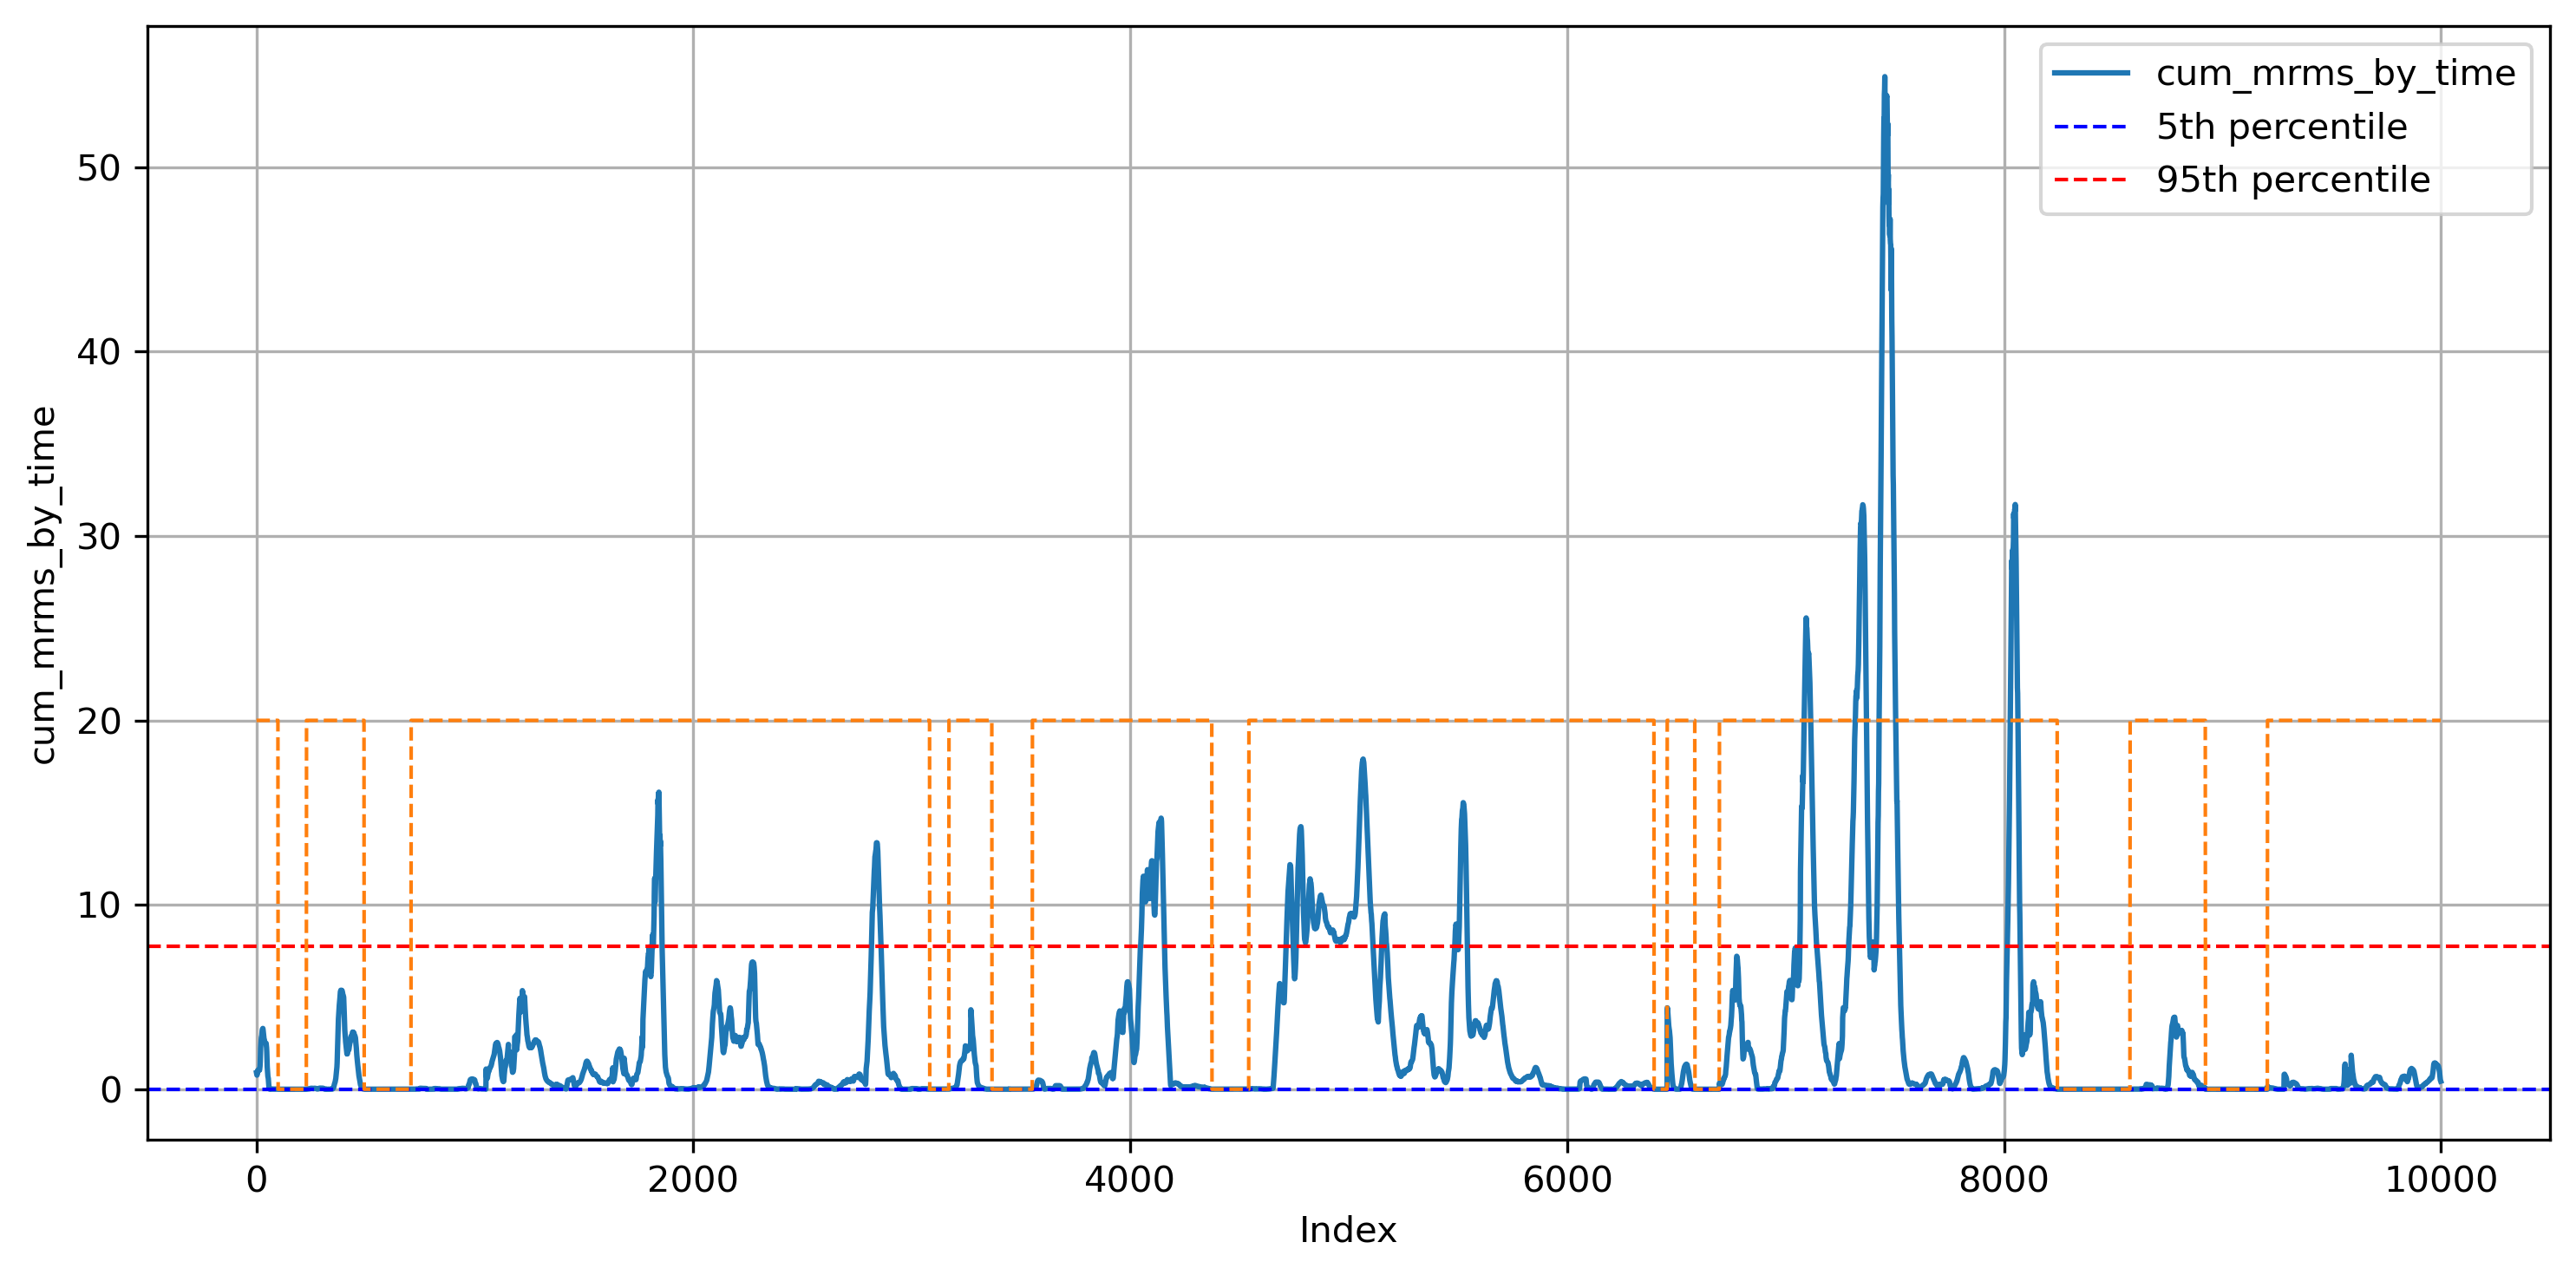

In [51]:
def crossings(y, thresh):
    """Return indices where the series crosses a horizontal threshold."""
    diff = y - thresh
    cross_idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0] + 1
    return cross_idx


low_hits  = crossings(series, p5)
high_hits = crossings(series, p95)

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.plot(x, series, label='cum_mrms_by_time')

# horizontal percentile lines
ax.axhline(p5,  color='blue',  linestyle='--',  linewidth=1, label='5th percentile')
ax.axhline(p95, color='red',   linestyle='--',  linewidth=1, label='95th percentile')

seen_events = set()
# for i, event in enumerate(rainfall_events):
#     if event not in seen_events:
#         color = "blue" if event != 0 else "red"
#         ax.axvline(i, linestyle='--',  color=color, linewidth=1, label=f"Rain Event: {event}")
#         seen_events.add(event)

# # intersection points
# ax.scatter(low_hits,  series[low_hits],  color='purple', marker='o',  zorder=3, label='Cross 5 %', s=10)
# ax.scatter(high_hits, series[high_hits], color='red',    marker='o',  zorder=3, label='Cross 95 %',s=10)

ax.plot(rainfall_events['is_event'] * 20, linestyle='--', linewidth=1.0)

ax.set_xlabel('Index')
ax.set_ylabel('cum_mrms_by_time')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

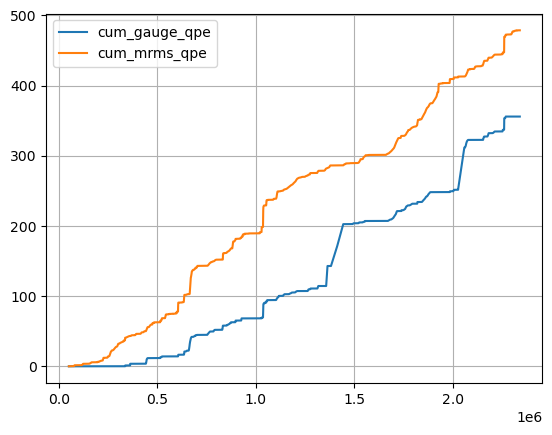

In [34]:
station_four  = df.loc[df['station_id'] == 4]
cum_gauge_qpe = station_four['cum_gauge_qpe']
cum_mrms_qpe  = station_four['cum_mrms_qpe']

plt.plot(cum_gauge_qpe, label="cum_gauge_qpe")
plt.plot(cum_mrms_qpe,  label="cum_mrms_qpe")
plt.grid()
plt.legend()
plt.show();

In [35]:
segment_rainfall_events(cum_mrms_qpe)

KeyError: 0

In [ ]:
data = cum_mrms_by_time
mean = data.mean()
p5   = data.quantile(0.05)
p95  = data.quantile(0.95)
p99  = data.quantile(0.99)

fig, ax = plt.subplots()

ax.hist(data, bins="auto", edgecolor='black')
ax.axvline(p5,   ymin=0, ymax=1000, color='tab:orange', linestyle='--', linewidth=1, label=f'5th pct: {p5:.2f}')
ax.axvline(mean, color='tab:red',    linestyle='-',  linewidth=1, label=f'Mean: {mean:.2f}')
ax.axvline(p95,  color='tab:blue',  linestyle='--', linewidth=1, label=f'95th pct: {p95:.2f}')
ax.axvline(p99,  color='tab:purple',  linestyle='--', linewidth=1, label=f'99th pct: {p99:.2f}')

ax.set_xlabel("Gauge QPE (in.)")
ax.set_ylabel("Frequency")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'cum_mrms_by_time' is not defined

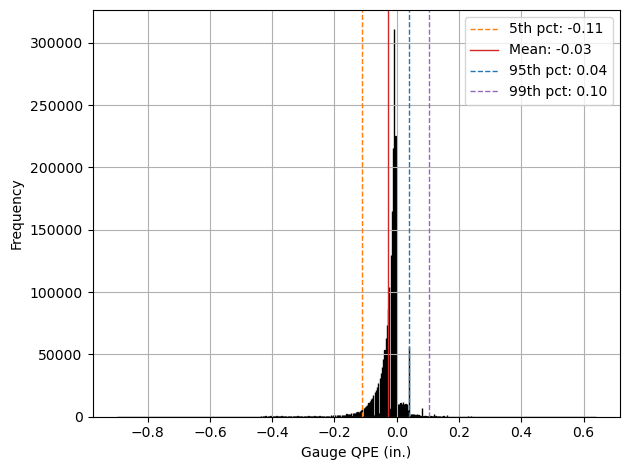

In [ ]:
data = df['delta_qpe']
mean = data.mean()
p5   = data.quantile(0.05)
p95  = data.quantile(0.95)
p99  = data.quantile(0.99)

fig, ax = plt.subplots()

ax.hist(data, bins="auto", edgecolor='black')
ax.axvline(p5,   ymin=0, ymax=1000, color='tab:orange', linestyle='--', linewidth=1, label=f'5th pct: {p5:.2f}')
ax.axvline(mean, color='tab:red',    linestyle='-',  linewidth=1, label=f'Mean: {mean:.2f}')
ax.axvline(p95,  color='tab:blue',  linestyle='--', linewidth=1, label=f'95th pct: {p95:.2f}')
ax.axvline(p99,  color='tab:purple',  linestyle='--', linewidth=1, label=f'99th pct: {p99:.2f}')

ax.set_xlabel("Gauge QPE (in.)")
ax.set_ylabel("Frequency")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

### 3. Enviornmental Analysis

#### 3.1. Major Correlates of `delta_qpe`